In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.utils

In [8]:
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('D:/ML/dataset/100k/ratings.csv', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Need to map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print ('Number of movies', num_movies)
print ('Number of users', num_users)

Number of movies 9066
Number of users 671


In [9]:
train.head()

,user_id,movie_id,rating,timestamp
78297,545,760,2.0,938566655
17033,111,88,1.5,1097432330
7643,48,3201,3.0,1339447164
67773,472,3680,3.0,948656089
87324,580,1529,4.0,1245424172


In [10]:
test.head()

,user_id,movie_id,rating,timestamp
64601,461,2754,2.0,1090909127
27409,199,576,4.0,1398939828
79239,547,1011,0.5,1109437677
6843,40,498,4.0,1466993488
75639,525,265,4.0,1024929697


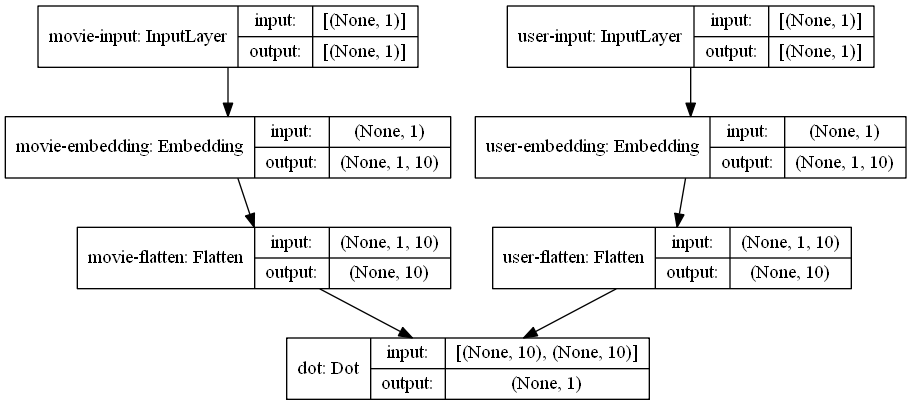

In [11]:
from keras.models import Model, Sequential
from keras.layers import *
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

latent_dim = 10

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = tf.keras.layers.Dot(axes=1)([movie_vec, user_vec])

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

plot_model(model, show_shapes=True)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding (Embedding)     (None, 1, 10)        90670       movie-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 10)        6720        user-input[0][0]                 
______________________________________________________________________________________________

Epoch 1/10
2501/2501 [==============================] - 8s 3ms/step - loss: 13.0682
Epoch 2/10
2501/2501 [==============================] - 7s 3ms/step - loss: 4.5842
Epoch 3/10
2501/2501 [==============================] - 7s 3ms/step - loss: 2.1376
Epoch 4/10
2501/2501 [==============================] - 7s 3ms/step - loss: 1.4210
Epoch 5/10
2501/2501 [==============================] - 7s 3ms/step - loss: 1.1053
Epoch 6/10
2501/2501 [==============================] - 7s 3ms/step - loss: 0.9584
Epoch 7/10
2501/2501 [==============================] - 7s 3ms/step - loss: 0.8707
Epoch 8/10
2501/2501 [==============================] - 7s 3ms/step - loss: 0.8166
Epoch 9/10
2501/2501 [==============================] - 6s 3ms/step - loss: 0.7697
Epoch 10/10
2501/2501 [==============================] - 7s 3ms/step - loss: 0.7368


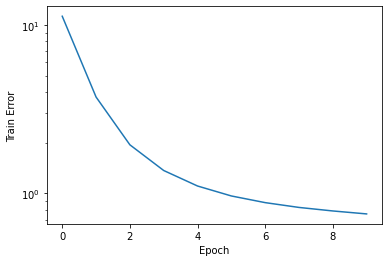

0.7884125788071923

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

In [15]:
from keras.constraints import non_neg

latent_dim = 5

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding',
                                                        embeddings_constraint=non_neg())(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding',
                                                      embeddings_constraint=non_neg())(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

#prod = merge([movie_vec, user_vec], mode='dot',name='dot-product')

prod = tf.keras.layers.Dot(axes=1)([movie_vec, user_vec])

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

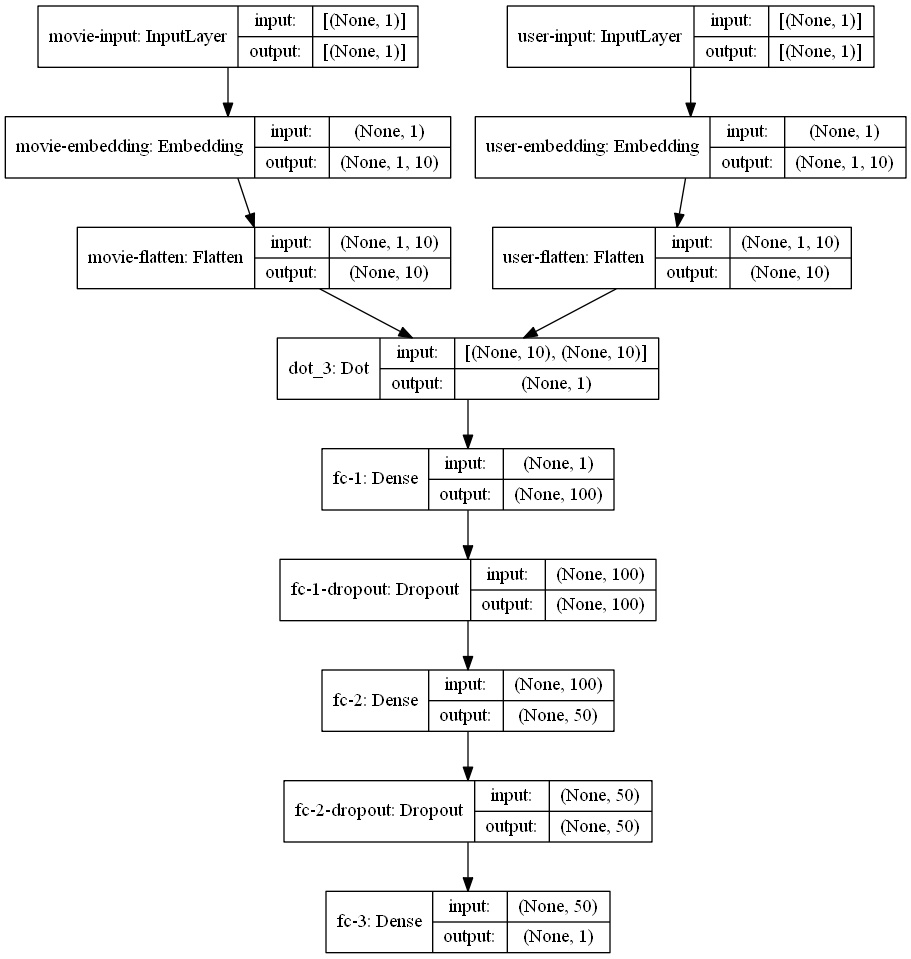

In [16]:
#neural network with MF starts here
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, Dropout, Dense
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

latent_dim = 10

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = tf.keras.layers.Dot(axes=1)([movie_vec, user_vec])

fc_1 = Dense(100, name='fc-1', activation='relu')(prod)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)

model = Model([user_input, movie_input], fc_3)

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
plot_model(model, show_shapes=True) #why is this extra line here

In [17]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding (Embedding)     (None, 1, 10)        90670       movie-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 10)        6720        user-input[0][0]                 
____________________________________________________________________________________________

Epoch 1/10
2501/2501 [==============================] - 11s 4ms/step - loss: 1.4654
Epoch 2/10
2501/2501 [==============================] - 10s 4ms/step - loss: 0.9717
Epoch 3/10
2501/2501 [==============================] - 10s 4ms/step - loss: 0.8407
Epoch 4/10
2501/2501 [==============================] - 10s 4ms/step - loss: 0.7720
Epoch 5/10
2501/2501 [==============================] - 10s 4ms/step - loss: 0.7189
Epoch 6/10
2501/2501 [==============================] - 10s 4ms/step - loss: 0.6817
Epoch 7/10
2501/2501 [==============================] - 10s 4ms/step - loss: 0.6607
Epoch 8/10
2501/2501 [==============================] - 11s 4ms/step - loss: 0.6364
Epoch 9/10
2501/2501 [==============================] - 11s 4ms/step - loss: 0.6226
Epoch 10/10
2501/2501 [==============================] - 11s 4ms/step - loss: 0.6115


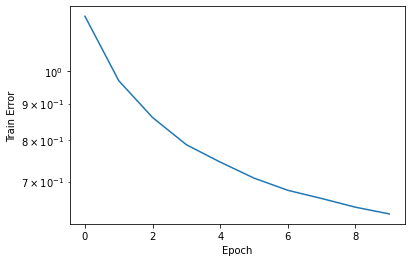

0.8494405273341946

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

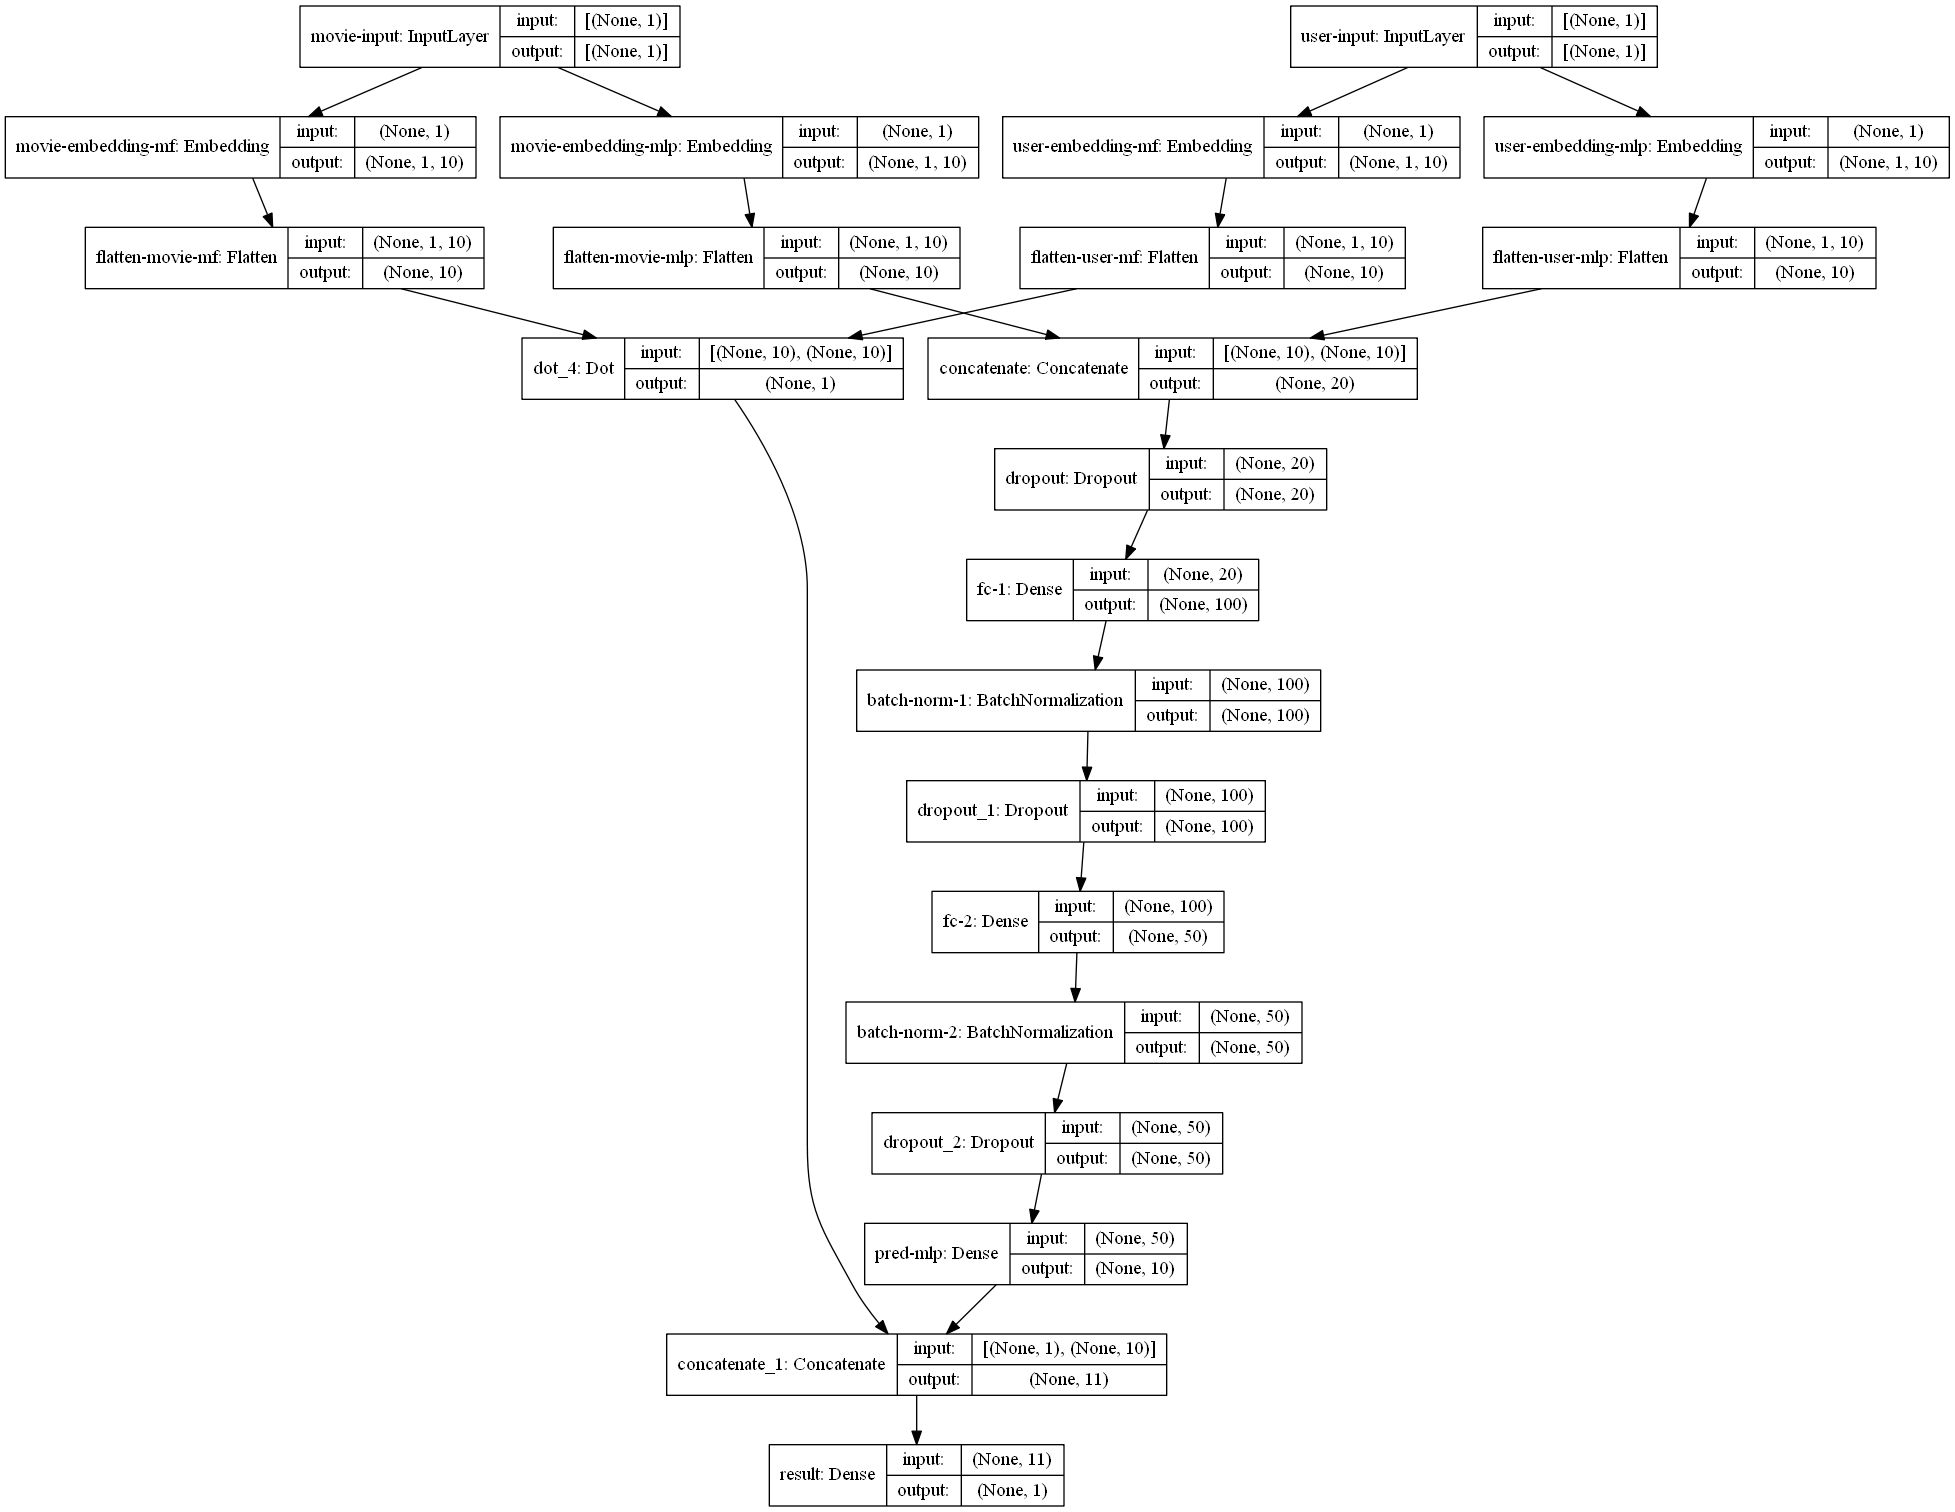

In [19]:
#multi-layer perceptor starts here
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

latent_dim = 10

# Define inputs
movie_input = Input(shape=[1],name='movie-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
movie_embedding_mlp = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mlp')(movie_input)
movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
movie_embedding_mf = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mf')(movie_input)
movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = tf.keras.layers.Concatenate(axis=-1)([movie_vec_mlp, user_vec_mlp])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = tf.keras.layers.Dot(axes=1)([movie_vec_mf, user_vec_mf])
combine_mlp_mf = tf.keras.layers.Concatenate(axis=-1)([pred_mf, pred_mlp])

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, movie_input], result)
model.compile(optimizer=Adam(lr=0.01), loss='mean_absolute_error')
plot_model(model, show_shapes=True)

In [20]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding-mlp (Embedding) (None, 1, 10)        90670       movie-input[0][0]                
__________________________________________________________________________________________________
user-embedding-mlp (Embedding)  (None, 1, 10)        6720        user-input[0][0]                 
____________________________________________________________________________________________

Epoch 1/10
2501/2501 [==============================] - 18s 7ms/step - loss: 0.9454
Epoch 2/10
2501/2501 [==============================] - 17s 7ms/step - loss: 0.6630
Epoch 3/10
2501/2501 [==============================] - 17s 7ms/step - loss: 0.5790
Epoch 4/10
2501/2501 [==============================] - 17s 7ms/step - loss: 0.5287
Epoch 5/10
2501/2501 [==============================] - 17s 7ms/step - loss: 0.4956
Epoch 6/10
2501/2501 [==============================] - 17s 7ms/step - loss: 0.4779
Epoch 7/10
2501/2501 [==============================] - 17s 7ms/step - loss: 0.4603
Epoch 8/10
2501/2501 [==============================] - 17s 7ms/step - loss: 0.4483
Epoch 9/10
2501/2501 [==============================] - 18s 7ms/step - loss: 0.4422
Epoch 10/10
2501/2501 [==============================] - 17s 7ms/step - loss: 0.4303


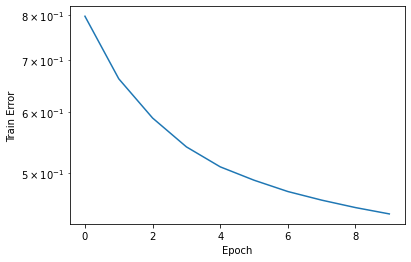

0.7799540034454179

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)